In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u

# 讀取資料
df= pd.read_csv("https://docs.google.com/spreadsheets/d/1CKdG7vZ8LacDUbQsLGTs8X2tDDWG1UNm/export?format=csv")


#清除空白資料
df_cleaned = df.dropna(subset=['ra', 'dec', 'pmra', 'pmdec', 'RV', 'distance'])
ra, dec, pmra, pmdec, RV, parallax= df_cleaned['ra'].values, df_cleaned['dec'].values, df_cleaned['pmra'].values, df_cleaned['pmdec'].values, df_cleaned['RV'].values, df_cleaned['distance'].values

ra = df_cleaned['ra'].values
dec = df_cleaned['dec'].values
pmra = df_cleaned['pmra'].values
pmdec = df_cleaned['pmdec'].values
RV = df_cleaned['RV'].values
distance = df_cleaned['distance'].values
parallax = 1000 / distance

for col in ['ra', 'dec', 'pmra', 'pmdec', 'RV', 'distance']:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# 轉換數據為 numpy 陣列
ra, dec = df_cleaned['ra'].values, df_cleaned['dec'].values
pmra, pmdec = df_cleaned['pmra'].values, df_cleaned['pmdec'].values
RV, distance = df_cleaned['RV'].values, df_cleaned['distance'].values


# 轉換到銀心座標系
coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, radial_velocity=RV*u.km/u.s, distance=distance*u.pc, frame='icrs')
galactocentric = coords.transform_to(Galactocentric)


# 提取銀心坐標中的X, Y, Z 位置和速度分量
X, Y, Z = galactocentric.x.to(u.kpc).value, galactocentric.y.to(u.kpc).value, galactocentric.z.to(u.kpc).value
v_x, v_y, v_z = galactocentric.v_x.to(u.km/u.s).value, galactocentric.v_y.to(u.km/u.s).value, galactocentric.v_z.to(u.km/u.s).value

df_cleaned['X'] = X
df_cleaned['Y'] = Y
df_cleaned['Z'] = Z
df_cleaned['v_x'] = v_x
df_cleaned['v_y'] = v_y
df_cleaned['v_z'] = v_z
df_cleaned['distance_to_gc'] = np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2 + df_cleaned['Z']**2)
max_range = np.max([np.max(np.abs(X)), np.max(np.abs(Y)), np.max(np.abs(Z))])

# 定義位置條件和標籤
conditions = [
    (np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2 + df_cleaned['Z']**2) < 3),  #核球
    (np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2) < 21) & (np.abs(df_cleaned['Z']) <  1.35),  #銀盤
    (np.abs(df_cleaned['Z']) > 1.35) | (np.sqrt(df_cleaned['X']**2 + df_cleaned['Y']**2) > 21),  #銀暈
]
choices = ['Bulge', 'Disk', 'Halo']


# 新增 'Location' 欄位
df_cleaned['Location'] = np.select(conditions, choices, default='Unknown')

bulge = df_cleaned[(df_cleaned['Location'] == 'Bulge') & df_cleaned['X'].notna()]
disk = df_cleaned[(df_cleaned['Location'] == 'Disk') & df_cleaned['X'].notna()]
halo = df_cleaned[(df_cleaned['Location'] == 'Halo') & df_cleaned['X'].notna()]


# 繪製 3D 散點圖(色階)
# 轉換 Fe/H 為數值並移除 NaN
df_cleaned['Fe/H'] = pd.to_numeric(df_cleaned['Fe/H'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Fe/H'])

# 移除 Fe/H 數值異常點
feh_min = df_cleaned['Fe/H'].quantile(0.01)
feh_max = df_cleaned['Fe/H'].quantile(0.99)
df_cleaned = df_cleaned[(df_cleaned['Fe/H'] >= feh_min) & (df_cleaned['Fe/H'] <= feh_max)]
df_cleaned['Fe/H'] = df_cleaned['Fe/H'].clip(lower=feh_min, upper=feh_max)
fig_metallicity = go.Figure()

df_cleaned['hover_text'] = df_cleaned.apply(lambda row:
        f"Name: {row['Name']}<br>" +
        f"Distance to GC: {row['distance_to_gc']:.2f} kpc<br>" +
        f"Location: {row['Location']}", axis=1)

fig_metallicity.add_trace(go.Scatter3d(
    x=df_cleaned['X'],
    y=df_cleaned['Y'],
    z=df_cleaned['Z'],
    mode='markers',
    marker=dict(
        size=6,
        color=df_cleaned['Fe/H'],
        colorscale='Viridis_r',
        cmin=feh_min,
        cmax=feh_max,
        colorbar=dict(
            title='[Fe/H]',
            tickvals=np.linspace(feh_min, feh_max, num=6),
            ticktext=[f"{val:.2f}" for val in np.linspace(feh_min, feh_max, num=6)],
            len=0.8,
            thickness=20,
            x=1.1
        ),
        opacity=0.7
    ),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name='Star Clusters'
))


earth_x = -8.122
earth_y = 0
earth_z = 0.027
fig_metallicity.add_trace(go.Scatter3d(
    x=[earth_x],
    y=[earth_y],
    z=[earth_z],
    mode='markers+text',
    marker=dict(
        size=10,
        color='navy',
        opacity=1
    ),
    text=["Earth"],
    textposition="bottom center",
    name="Earth"
))


fig_metallicity.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers+text',
    marker=dict(
        size=10,
        color='crimson',
        opacity=1
    ),
    text=["Galactic Core"],
    textposition="bottom center",
    name="Galactic Core",
    legendgroup='Galactic Core',
    showlegend=True
))


fig_metallicity.update_layout(
    title='星團分布 (銀心座標系) - Fe/H 色階',
    scene=dict(
        xaxis=dict(range=[-max_range, max_range], title='X (kpc)'),
        yaxis=dict(range=[-max_range, max_range], title='Y (kpc)'),
        zaxis=dict(range=[-max_range, max_range], title='Z (kpc)'),
        aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    showlegend=True
)

fig_metallicity.show()

#繪製 3D 散點圖(以100和400為分界)
# 設定顏色條件
small_cluster = df_cleaned[df_cleaned['Fe/H'] < -1]
middle_cluster = df_cleaned[(df_cleaned['Fe/H'] > -1) & (df_cleaned['Fe/H'] < -0.5)]
large_cluster = df_cleaned[df_cleaned['Fe/H'] > -0.5]

# 計算最大範圍
max_range = np.max([np.max(np.abs(df_cleaned['X'])), np.max(np.abs(df_cleaned['Y'])), np.max(np.abs(df_cleaned['Z']))])

# 建立 3D 圖表
fig = go.Figure()

# N < 100
fig.add_trace(go.Scatter3d(
    x=small_cluster['X'],
    y=small_cluster['Y'],
    z=small_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='deepskyblue', opacity=0.7),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name='[Fe/H] < -1'
))

fig.add_trace(go.Scatter3d(
    x=middle_cluster['X'],
    y=middle_cluster['Y'],
    z=middle_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='orange', opacity=0.7),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name='-1 < [Fe/H] < -0.5'
))

# N > 400
fig.add_trace(go.Scatter3d(
    x=large_cluster['X'],
    y=large_cluster['Y'],
    z=large_cluster['Z'],
    mode='markers',
    marker=dict(size=6, color='purple', opacity=0.7),
    text=df_cleaned['hover_text'],
    hoverinfo='text',
    name='[Fe/H] > -0.5'
))
earth_x = -8.122
earth_y = 0
earth_z = 0.027
fig.add_trace(go.Scatter3d(
    x=[earth_x],
    y=[earth_y],
    z=[earth_z],
    mode='markers+text',
    marker=dict(
        size=10,
        color='navy',
        opacity=1
    ),
    text=["Earth"],
    textposition="bottom center",
    name="Earth"
))


fig.add_trace(go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers+text',
    marker=dict(
        size=10,
        color='crimson',
        opacity=1
    ),
    text=["Galactic Core"],
    textposition="bottom center",
    name="Galactic Core",
    legendgroup='Galactic Core',
    showlegend=True
))

fig.update_layout(
    title='星團分布 (銀心座標系) - 以-1與-0.5為分界',
    scene=dict(
        xaxis=dict(range=[-max_range, max_range], title='X (kpc)'),
        yaxis=dict(range=[-max_range, max_range], title='Y (kpc)'),
        zaxis=dict(range=[-max_range, max_range], title='Z (kpc)'),
        aspectmode='cube',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40),
    showlegend=True
)
fig.show()


output_csv_path = '疏散星團分布_GC20.csv'
df_cleaned.to_csv(output_csv_path, index=False)

from google.colab import files
files.download('疏散星團分布_GC20.csv')

fig.write_html("疏散星團分布_GC20.html")
from google.colab import files
files.download("疏散星團分布_GC20.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 檢查還是否有 NaN 值
print("Fe/H 欄位的 NaN 數量：", df_cleaned['Fe/H'].isna().sum())


Fe/H 欄位的 NaN 數量： 2611


<ipython-input-3-cb9618e2851f>:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-3-cb9618e2851f>:61: UserWarning:

Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from font(s) DejaVu Sans.

<ipython-input-3-cb9618e2851f>:61: UserWarning:

Glyph 22296 (\N{CJK UNIFIED IDEOGRAPH-5718}) missing from font(s) DejaVu Sans.

<ipython-input-3-cb9618e2851f>:61: UserWarning:

Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.

<ipython-input-3-cb9618e2851f>:61: UserWarning:

Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.

<ipython-input-3-cb9618e2851f>:61: UserWarning:

Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.

<ipython-input-3-cb9618e2851f>:61: UserWarning:

Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) mi

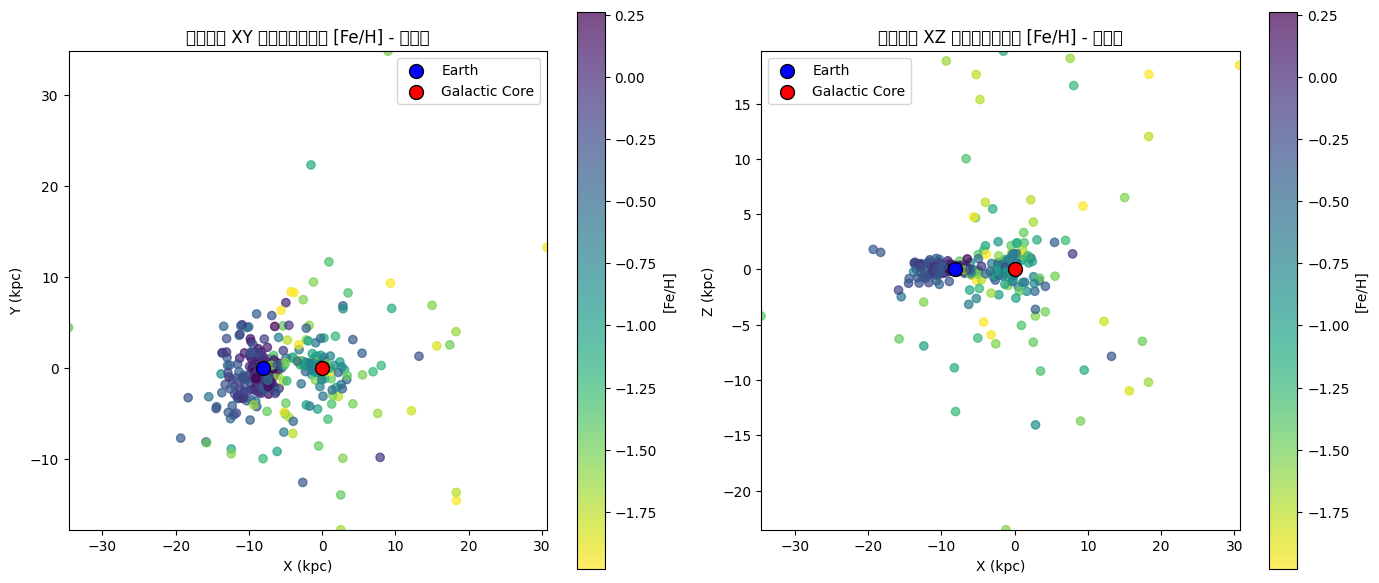

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 確保 'Fe/H' 是數值
df_cleaned['Fe/H'] = pd.to_numeric(df_cleaned['Fe/H'], errors='coerce')

# 過濾 NaN
df_cleaned = df_cleaned.dropna(subset=['X', 'Y', 'Z', 'Fe/H'])

# 計算色階範圍
feh_min = df_cleaned['Fe/H'].quantile(0.01)
feh_max = df_cleaned['Fe/H'].quantile(0.99)

# 設定銀河中心和地球的位置
earth_x, earth_y, earth_z = -8.122, 0, 0.027
galactic_core_x, galactic_core_y, galactic_core_z = 0, 0, 0  # 銀河中心

# 設定圖表大小
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 計算 XY 和 XZ 平面的範圍，確保 0 在範圍內
x_min, x_max = min(df_cleaned['X'].min(), 0), df_cleaned['X'].max()
y_min, y_max = min(df_cleaned['Y'].min(), 0), df_cleaned['Y'].max()
z_min, z_max = min(df_cleaned['Z'].min(), 0), df_cleaned['Z'].max()

# 計算 XY 和 XZ 平面的比例
xy_aspect = (x_max - x_min) / (y_max - y_min) if (y_max - y_min) != 0 else 1
xz_aspect = (x_max - x_min) / (z_max - z_min) if (z_max - z_min) != 0 else 1

# 反轉色階
cmap_reversed = plt.cm.get_cmap('viridis_r')  # 使用 Viridis 的反轉版本

# ======= XY 平面投影 (X vs Y) =======
sc1 = axes[0].scatter(df_cleaned['X'], df_cleaned['Y'], c=df_cleaned['Fe/H'], cmap=cmap_reversed, vmin=feh_min, vmax=feh_max, alpha=0.7)
axes[0].scatter(earth_x, earth_y, color='blue', s=100, label='Earth', edgecolors='black')
axes[0].scatter(galactic_core_x, galactic_core_y, color='red', s=100, label='Galactic Core', edgecolors='black')  # 銀河中心
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_aspect(aspect=xy_aspect)  # 確保XY比例相同
axes[0].set_title(' ')
axes[0].legend()
plt.colorbar(sc1, ax=axes[0], label='[Fe/H]')

# ======= XZ 平面投影 (X vs Z) =======
sc2 = axes[1].scatter(df_cleaned['X'], df_cleaned['Z'], c=df_cleaned['Fe/H'], cmap=cmap_reversed, vmin=feh_min, vmax=feh_max, alpha=0.7)
axes[1].scatter(earth_x, earth_z, color='blue', s=100, label='Earth', edgecolors='black')
axes[1].scatter(galactic_core_x, galactic_core_z, color='red', s=100, label='Galactic Core', edgecolors='black')  # 銀河中心
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(z_min, z_max)
axes[1].set_aspect(aspect=xz_aspect)  # 確保XZ比例相同
axes[1].set_title(' ')
axes[1].legend()
plt.colorbar(sc2, ax=axes[1], label='[Fe/H]')

# 顯示圖表
plt.tight_layout()
plt.show()
